# Quick Demo (Notebook version)

(I hate notebooks.)

In this demo, we will create a simple method and apply it to various Continual Learning settings.

For the purposes of this demo, we will restrict ourselves to classification problems on the mnist and fashion-mnist datasets.

In [1]:
# Imports:
from dataclasses import dataclass
from typing import Dict, Tuple, Type, Optional
import sys
sys.path.extend([".", ".."])
import gym
import torch
from gym import spaces
from torch import Tensor, nn

from settings import Setting, Method
from settings.passive.cl import ClassIncrementalSetting
from settings.passive.cl.objects import (Actions, Observations,
                                         PassiveEnvironment, Results, Rewards)

# Basic Model:

In [2]:

class MyModel(nn.Module):
    """ Simple classification model without any CL-related mechanism.

    To keep things simple, this demo model is designed for supervised
    (classification) settings where observations have shape [3, 28, 28] (ie the
    MNIST variants: Mnist, FashionMnist, RotatedMnist, EMnist, etc.)
    """
    def __init__(self,
                 observation_space: gym.Space,
                 action_space: gym.Space,
                 reward_space: gym.Space):
        super().__init__()
        image_shape = observation_space[0].shape
        assert image_shape == (3, 28, 28)
        assert isinstance(action_space, spaces.Discrete)
        assert action_space == reward_space
        n_classes = action_space.n
        image_channels = image_shape[0]

        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, n_classes),
        )
        self.loss = nn.CrossEntropyLoss()

    def forward(self, observations: Observations) -> Tensor:
        # NOTE: here we don't make use of the task labels.
        x, task_labels = observations
        features = self.encoder(x)
        logits = self.classifier(features)
        return logits

    def training_step(self, batch: Tuple[Observations, Rewards], *args, **kwargs):
        return self.shared_step(batch, *args, **kwargs)

    def validation_step(self, batch: Tuple[Observations, Rewards], *args, **kwargs):
        return self.shared_step(batch, *args, **kwargs)

    def shared_step(self, batch: Tuple[Observations, Rewards], *args, **kwargs):
        # Since we're training on a Passive environment, we get both
        # observations and rewards.
        observations: Observations = batch[0]
        rewards: Rewards = batch[1]
        image_labels = rewards.y

        # Get the predictions:
        logits = self(observations)
        y_pred = logits.argmax(-1)

        loss = self.loss(logits, image_labels)

        accuracy = (y_pred == image_labels).sum().float() / len(image_labels)
        metrics_dict = {"accuracy": accuracy}
        return loss, metrics_dict

## Creating our Method

Here by subclassing 'MethodABC' and passing in a target_setting, we indicate that we are creating a new method, and that it will work on any Setting that is an instance of ClassIncrementalSetting or one of its subclasses. 

In [3]:

class DemoMethod(Method, target_setting=ClassIncrementalSetting):
    """ Minimal example of a Method targetting the Class-Incremental CL setting.
    
    For a quick intro to dataclasses, see examples/dataclasses_example.py    
    """

    @dataclass
    class HParams:
        """ Hyper-parameters of the demo model. """
        # Learning rate of the optimizer.
        learning_rate: float = 0.001
    
    def __init__(self, hparams: HParams):
        self.hparams: DemoMethod.HParams = hparams
        self.max_epochs: int = 1
        self.early_stop_patience: int = 2

        # We will create those when `configure` will be called, before training.
        self.model: MyModel
        self.optimizer: torch.optim.Optimizer

    def configure(self, setting: ClassIncrementalSetting):
        """ Called before the method is applied on a setting (before training). 

        You can use this to instantiate your model, for instance, since this is
        where you get access to the observation & action spaces.
        """
        self.model = MyModel(
            observation_space=setting.observation_space,
            action_space=setting.action_space,
            reward_space=setting.reward_space,
        )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hparams.learning_rate)

    def fit(self, train_env: PassiveEnvironment, valid_env: PassiveEnvironment):
        # configure() will have been called by the setting before we get here.
        import tqdm
        from numpy import inf
        best_val_loss = inf
        best_epoch = 0
        for epoch in range(self.max_epochs):
            self.model.train()
            # Training loop:
            with tqdm.tqdm(train_env) as train_pbar:
                train_pbar.set_description(f"Training Epoch {epoch}")
                for i, batch in enumerate(train_pbar):
                    loss, metrics_dict = self.model.training_step(batch)
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    train_pbar.set_postfix(**metrics_dict)

            # Validation loop:
            self.model.eval()
            torch.set_grad_enabled(False)
            with tqdm.tqdm(valid_env) as val_pbar:
                val_pbar.set_description(f"Validation Epoch {epoch}")
                epoch_val_loss = 0.

                for i, batch in enumerate(val_pbar):
                    batch_val_loss, metrics_dict = self.model.validation_step(batch)
                    epoch_val_loss += batch_val_loss
                    val_pbar.set_postfix(**metrics_dict, val_loss=epoch_val_loss)
            torch.set_grad_enabled(True)

            if epoch_val_loss < best_val_loss:
                best_val_loss = valid_env
                best_epoch = i
            if i - best_epoch > self.early_stop_patience:
                print(f"Early stopping at epoch {i}.")

    def get_actions(self, observations: Observations, action_space: gym.Space) -> Actions:
        """ Get a batch of predictions (aka actions) for these observations. """ 
        with torch.no_grad():
            logits = self.model(observations)
        # Get the predicted classes
        y_pred = logits.argmax(dim=-1)
        return self.target_setting.Actions(y_pred)


def create_method(DemoMethod = DemoMethod) -> DemoMethod:
    from simple_parsing import ArgumentParser
    
    # Get the hparams of the method from the command-line.
    parser = ArgumentParser(description=__doc__)
    parser.add_arguments(DemoMethod.HParams, dest="hparams")
    args = parser.parse_args()
    hparams: DemoMethod.HParams = args.hparams

    # Create the method and return it.
    method = DemoMethod(hparams=hparams)
    return method


In [4]:
method = DemoMethod(hparams=DemoMethod.HParams())
setting = ClassIncrementalSetting(dataset="fashionmnist")

results = setting.apply(method)

2020-10-15:19:00:48,849 WARNING  [../utils/parseable.py:30] Unknown/unused args when parsing class <class 'common.config.config.Config'>: ['-f', '/home/fabrice/.local/share/jupyter/runtime/kernel-6d98cd47-7ba3-4992-a3fe-6087ba375c74.json']
0it [00:00, ?it/s]Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz to data/FashionMNIST/raw/train-images-idx3-ubyte.gz
 99%|█████████▉| 26165248/26421880 [00:03<00:00, 11672179.28it/s]Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw

0it [00:00, ?it/s]Downloading http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw/train-labels-idx1-ubyte.gz

  0%|          | 0/29515 [00:00<?, ?it/s]

0it [00:00, ?it/s]Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw


  0%|          | 0/4422102 [00:00<?, ?it/s]

  0%|          | 16384/4422102 [00:00<00:26, 163198.92it/s]

  2%|▏         | 7

## Results:

Test Results on task 0: ClassificationMetrics(n_samples=1984, accuracy=50.353%)
Test Results on task 1: ClassificationMetrics(n_samples=1984, accuracy=50.554%)
Test Results on task 2: ClassificationMetrics(n_samples=1984, accuracy=89.315%)
Test Results on task 3: ClassificationMetrics(n_samples=1984, accuracy=97.026%)
Test Results on task 4: ClassificationMetrics(n_samples=1984, accuracy=99.748%)
Average test metrics accross all the test tasks: ClassificationMetrics(n_samples=9920, accuracy=77.399%)



{'task_metrics': <Figure size 432x288 with 1 Axes>}

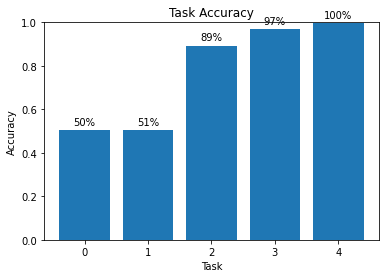

In [5]:
print(results.summary())
results.make_plots()

As you can see, our model's performance quickly deteriorates as new tasks are learned, a process refered to as "Catastrophic Forgetting".
Next, we'll try to do something about it.


## Adding a CL Mechanism

First, by taking a look at the logs above, you will notice that we are told that our Method doesn't have an `on_task_switch` method.

A Setting would call this `on_task_switch` method during training or evaluation if we are allowed to know when task boundaries occur in that setting. Additionally, if it's allowed in that Setting, we might also receive the index of the new task we are switching to.

Using this information, here we will add an EWC-like penalty to our model, which will prevent its weights from changing too much between tasks. We'll use the `on_task_switch` method to update the 'anchor' weights everytime a task boundary is encountered.


In [6]:
from copy import deepcopy
from utils import dict_intersection

class MyImprovedModel(MyModel):
    """ Adds an ewc-like penalty to the demo model. """
    def __init__(self,
                 observation_space: gym.Space,
                 action_space: gym.Space,
                 reward_space: gym.Space,
                 ewc_coefficient: float = 1.0,
                 ewc_p_norm: int = 2,
                 ):
        super().__init__(
            observation_space,
            action_space,
            reward_space,
        )
        self.ewc_coefficient = ewc_coefficient
        self.ewc_p_norm = ewc_p_norm

        self.previous_model_weights: Dict[str, Tensor] = {}

        self._previous_task: Optional[int] = None
        self._n_switches: int = 0

    def shared_step(self, batch: Tuple[Observations, Rewards], *args, **kwargs):
        base_loss, metrics = super().shared_step(batch, *args, **kwargs)
        ewc_loss = self.ewc_coefficient * self.ewc_loss()
        metrics["ewc_loss"] = ewc_loss
        return base_loss + ewc_loss, metrics

    def on_task_switch(self, task_id: Optional[int])-> None:
        """ Executed when the task switches (to either a known or unknown task).
        """
        if self._previous_task is None and self._n_switches == 0:
            print("Starting the first task, no EWC update.")
        elif task_id is None or task_id != self._previous_task:
            # NOTE: We also switch between unknown tasks.
            print(f"Switching tasks: {self._previous_task} -> {task_id}: ")
            print(f"Updating the EWC 'anchor' weights.")
            self._previous_task = task_id
            self.previous_model_weights.clear()
            self.previous_model_weights.update(deepcopy({
                k: v.detach() for k, v in self.named_parameters()
            }))
        self._n_switches += 1

    def ewc_loss(self) -> Tensor:
        """Gets an 'ewc-like' regularization loss.

        NOTE: This is a simplified version of EWC where the loss is the P-norm
        between the current weights and the weights as they were on the begining
        of the task.
        """
        if self._previous_task is None:
            # We're in the first task: do nothing.
            return 0.

        old_weights: Dict[str, Tensor] = self.previous_model_weights
        new_weights: Dict[str, Tensor] = dict(self.named_parameters())

        loss = 0.
        for weight_name, (new_w, old_w) in dict_intersection(new_weights, old_weights):
            loss += torch.dist(new_w, old_w.type_as(new_w), p=self.ewc_p_norm)
        return loss


In [7]:

class ImprovedDemoMethod(DemoMethod):
    """ Improved version of the demo method, that adds an ewc-like regularizer.
    """
    # Name of this method:    
    @dataclass
    class HParams(DemoMethod.HParams):
        """ Hyperparameters of this new improved method. (Adds ewc params)."""
        # Coefficient of the ewc-like loss.
        ewc_coefficient: float = 1.0
        # Distance norm used in the ewc loss.
        ewc_p_norm: int = 2

    def __init__(self, hparams: HParams):
        super().__init__(hparams=hparams)
    
    def configure(self, setting: ClassIncrementalSetting):
        # Use the improved model, with the added EWC-like term.
        self.model = MyImprovedModel(
            observation_space=setting.observation_space,
            action_space=setting.action_space,
            reward_space=setting.reward_space,
            ewc_coefficient=self.hparams.ewc_coefficient,
            ewc_p_norm = self.hparams.ewc_p_norm,
        )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hparams.learning_rate)

    def on_task_switch(self, task_id: Optional[int]):
        self.model.on_task_switch(task_id)

## Running the "Improved" method

In [8]:
improved_method = ImprovedDemoMethod(hparams=ImprovedDemoMethod.HParams())
setting = ClassIncrementalSetting(dataset="fashionmnist")

improved_results = setting.apply(improved_method)

2020-10-15:19:01:15,455 WARNING  [../utils/parseable.py:30] Unknown/unused args when parsing class <class 'common.config.config.Config'>: ['-f', '/home/fabrice/.local/share/jupyter/runtime/kernel-6d98cd47-7ba3-4992-a3fe-6087ba375c74.json']
2020-10-15:19:01:15,515 INFO     [../settings/passive/cl/class_incremental_setting.py:282] Number of train tasks: 5.
2020-10-15:19:01:15,515 INFO     [../settings/passive/cl/class_incremental_setting.py:283] Number of test tasks: 5.
2020-10-15:19:01:16,614 INFO     [../settings/passive/cl/class_incremental_setting.py:282] Number of train tasks: 5.
2020-10-15:19:01:16,615 INFO     [../settings/passive/cl/class_incremental_setting.py:283] Number of test tasks: 5.
2020-10-15:19:01:17,129 INFO     [../settings/assumptions/incremental.py:108] Starting training on task 0
Starting the first task, no EWC update.
Validation Epoch 0: 100%|██████████| 75/75 [00:00<00:00, 143.89it/s, accuracy=tensor(1.), ewc_loss=0, val_loss=tensor(2.6359)]
2020-10-15:19:01:19,9

In [9]:
## Improved Results

Test Results on task 0: ClassificationMetrics(n_samples=1984, accuracy=97.177%)
Test Results on task 1: ClassificationMetrics(n_samples=1984, accuracy=69.103%)
Test Results on task 2: ClassificationMetrics(n_samples=1984, accuracy=88.810%)
Test Results on task 3: ClassificationMetrics(n_samples=1984, accuracy=97.631%)
Test Results on task 4: ClassificationMetrics(n_samples=1984, accuracy=98.387%)
Average test metrics accross all the test tasks: ClassificationMetrics(n_samples=9920, accuracy=90.222%)



{'task_metrics': <Figure size 432x288 with 1 Axes>}

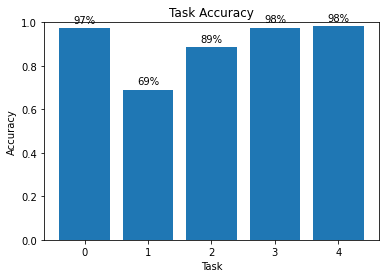

In [10]:
print(improved_results.summary())
improved_results.make_plots()

## Final Results


{'task_metrics': <Figure size 432x288 with 1 Axes>}

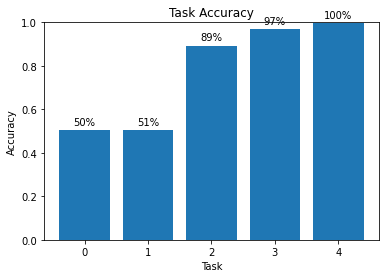

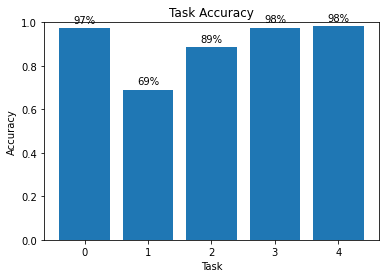

In [11]:
results.make_plots()
improved_results.make_plots()